In [1]:
import numpy as np
import numpy.ma as ma

from astropy.table import QTable, Table

import sys
sys.path.insert(1,"/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/")
#sys.path.insert(1, '/home/kelly/Documents/RotationCurves/spirals/')
from DRP_rotation_curve import extract_data
from DRP_vel_map_functions import model_vel_map, \
                                  find_center, \
                                  find_phi, \
                                  deproject_spaxel, \
                                  find_vel_bounds, \
                                  find_sigma_bounds
from DRP_vel_map_plottingFunctions import plot_rot_curve
from Pipe3D_vel_map import extract_Pipe3D_data

#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
MANGA_FOLDER = '/Users/kellydouglass/Documents/Research/data/SDSS/'
#MANGA_FOLDER = '/home/kelly/Documents/Data/SDSS/dr16/manga/spectro/'
DRP_FOLDER = MANGA_FOLDER + 'dr16/manga/spectro/analysis/v2_4_3/2.2.1/HYB10-GAU-MILESHC/'
PIPE3D_FOLDER = MANGA_FOLDER + 'dr15/manga/spectro/pipe3d/v2_4_3/2.4.3/'

In [3]:
#oneD_fit_file = '../spirals/DRPall-master_file_30.txt'
#oneD_fit_file = '../spirals/DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_noWords_v5.txt'
oneD_fit_file = '../spirals/DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_morph_noWords_v6.txt'

#oneD_fit_parameters = QTable.read(oneD_fit_file, format='ascii.ecsv')
oneD_fit_parameters = Table.read(oneD_fit_file, format='ascii.commented_header')

# Sample galaxy properties

In [4]:
#gal_ID = '7443-12705'
gal_ID = '8440-12704'

manga_plate, manga_IFU = gal_ID.split('-')

In [6]:
DRPmaps = extract_data(DRP_FOLDER, gal_ID, ['Ha_flux', 'Ha_vel', 'Ha_sigma', 'r_band', 'star_vel'])
star_vel, star_vel_err = extract_Pipe3D_data(PIPE3D_FOLDER, gal_ID)

mStar_vel = ma.array(star_vel, mask=((star_vel_err > 25) | np.isnan(star_vel) | (star_vel == 0))) 

mr_band = ma.array(DRPmaps['r_band'], mask=DRPmaps['Ha_vel_mask'])
mHa_vel = ma.array(DRPmaps['Ha_vel'], mask=DRPmaps['Ha_vel_mask'])
mHa_vel_ivar = ma.array(DRPmaps['Ha_vel_ivar'], mask=DRPmaps['Ha_vel_mask'])

mHa_sigma = ma.array(DRPmaps['Ha_sigma'], 
                     mask=DRPmaps['Ha_sigma_mask'] + DRPmaps['Ha_vel_mask'])#np.logical_or(Ha_sigma_mask > 0, Ha_vel_mask > 0))
mHa_sigma_ivar = ma.array(DRPmaps['Ha_sigma_ivar'], 
                          mask=DRPmaps['Ha_sigma_mask'] + DRPmaps['Ha_vel_mask'])

SN = DRPmaps['Ha_flux']*np.sqrt(DRPmaps['Ha_flux_ivar'])
m5Ha_vel = ma.array(DRPmaps['Ha_vel'], 
                    mask=np.logical_or(DRPmaps['Ha_vel_mask'] > 0, np.abs(SN) < 5))#0.05*np.max(np.abs(SN))))
print('5% of the maximum S/N:', 0.05*np.max(np.abs(SN)))

5% of the maximum S/N: 5.62565803527832


In [7]:
gal_oneD_fit_parameters_boolean = np.logical_and(oneD_fit_parameters['MaNGA_plate'] == int(manga_plate), 
                                                 oneD_fit_parameters['MaNGA_IFU'] == int(manga_IFU))

gal_oneD_fit_parameters_row = oneD_fit_parameters[gal_oneD_fit_parameters_boolean]

In [8]:
H_0 = 100      # Hubble's Constant in units of h km/s/Mpc
c = 299792.458 # Speed of light in units of km/s

MANGA_FIBER_DIAMETER = 2*(1/60)*(1/60)*(np.pi/180) # angular fiber diameter (2") in radians
MANGA_SPAXEL_SIZE = 0.5*(1/60)*(1/60)*(np.pi/180)  # spaxel size (0.5") in radians


#dist_to_galaxy_Mpc = c*gal_oneD_fit_parameters_row['redshift'][0]/H_0
dist_to_galaxy_Mpc = c*gal_oneD_fit_parameters_row['NSA_redshift'][0]/H_0
dist_to_galaxy_kpc = dist_to_galaxy_Mpc*1000

pix_scale_factor = dist_to_galaxy_kpc*np.tan(MANGA_SPAXEL_SIZE)

#print(pix_scale_factor)

In [9]:
################################################################################
# Inclination angle (from photometry)
#-------------------------------------------------------------------------------
print('ba:', gal_oneD_fit_parameters_row['NSA_ba'][0])
i_angle = np.arccos(gal_oneD_fit_parameters_row['NSA_ba'][0])
'''
q0 = 0.2
i_angle2 = np.arccos(np.sqrt((gal_oneD_fit_parameters_row['NSA_ba'][0]**2 - q0**2)/(1 - q0**2)))
print('sin(i) (map fit, corrected):', np.sin(i_angle), np.sin(i_angle2))
''';
i_angle_map_fit = np.arccos(gal_oneD_fit_parameters_row['ba_map'][0])
print('ba from map fit:', gal_oneD_fit_parameters_row['ba_map'][0])
################################################################################


################################################################################
# Photometric center of galaxy
#-------------------------------------------------------------------------------
center = np.unravel_index(ma.argmax(mr_band), mr_band.shape)

if gal_ID == '8613-12701':
    center = (40,35)
elif gal_ID == '8134-3701':
    center = (22,22)
elif gal_ID == '7958-12703':
    center = (39,39)

x0 = gal_oneD_fit_parameters_row['x0_map'][0]
y0 = gal_oneD_fit_parameters_row['y0_map'][0]
################################################################################


################################################################################
# Systemic velocity (velocity at galaxy's center)
#-------------------------------------------------------------------------------
v_sys = mHa_vel[center]

v_sys_map_fit = gal_oneD_fit_parameters_row['Vsys_map'][0]
################################################################################


################################################################################
# Rotation angle (from photometry)
#-------------------------------------------------------------------------------
phi = gal_oneD_fit_parameters_row['NSA_phi'][0]#.value
#phi = 11.8158

phi_guess = find_phi(center, phi, mHa_vel)

phi_map_fit = gal_oneD_fit_parameters_row['phi_map'][0]

print('Phi (from photometry, initial guess, fit from the map):', phi, phi_guess*180/np.pi, phi_map_fit)
################################################################################


################################################################################
# Curve used (for 1D fit)
#-------------------------------------------------------------------------------
'''
curve = gal_oneD_fit_parameters_row['curve_used'][0]

if curve in ['none', 'non']:
    curve = 'avg'
'''
best_rot_curve = gal_oneD_fit_parameters_row['curve_used'][0]

if best_rot_curve == -1:
    curve = 'neg'
elif best_rot_curve == 1:
    curve = 'pos'
else:
    curve = 'avg'

print(best_rot_curve, curve)
################################################################################


################################################################################
# Maximum velocity
#-------------------------------------------------------------------------------
v_max = gal_oneD_fit_parameters_row[curve + '_v_max'][0]#.value

v_max_index = np.unravel_index(ma.argmax(np.abs(mHa_vel)), mHa_vel.shape)
v_max_guess = np.abs(mHa_vel[v_max_index]/np.sin(i_angle))

v_max_map_fit = gal_oneD_fit_parameters_row['Vmax_map'][0]
################################################################################


################################################################################
# Turn radius
#-------------------------------------------------------------------------------
r_turn = gal_oneD_fit_parameters_row[curve + '_r_turn'][0]#.value

r_turn_guess_spaxels,_ = deproject_spaxel(v_max_index, 
                                          center, 
                                          phi_guess, 
                                          i_angle)

r_turn_guess = 0.5*r_turn_guess_spaxels*pix_scale_factor

if r_turn_guess < 0.01:
    r_turn_guess = 1.1*0.01
    
r_turn_map_fit = gal_oneD_fit_parameters_row['Rturn_map'][0]
################################################################################


################################################################################
# alpha
#-------------------------------------------------------------------------------
alpha = gal_oneD_fit_parameters_row[curve + '_alpha'][0]

alpha_guess = 2

alpha_map_fit = gal_oneD_fit_parameters_row['alpha_map'][0]
################################################################################


params = [v_sys, i_angle, center[0], center[1], phi_guess, v_max, r_turn, alpha]
initial_guess_params = [v_sys, 
                        i_angle, 
                        center[0], 
                        center[1], 
                        phi_guess, 
                        v_max_guess, 
                        r_turn_guess, 
                        alpha_guess]
map_fit_params = [v_sys_map_fit,
                  i_angle_map_fit,
                  x0,
                  y0,
                  phi_map_fit*np.pi/180.,
                  v_max_map_fit,
                  r_turn_map_fit,
                  alpha_map_fit]

print('1D parameters:', params)
print('Initial guess:', initial_guess_params)
print('Fitted map:', map_fit_params)

best_fit_values = {'v_sys':v_sys,
                   'ba':gal_oneD_fit_parameters_row['NSA_ba'][0],
                   'x0':center[0],
                   'y0':center[1],
                   'phi':phi_guess,
                   'r_turn':r_turn,
                   'v_max':v_max,
                   'alpha':alpha}
best_fit_values_degrees = {'v_sys':v_sys,
                           'ba':gal_oneD_fit_parameters_row['NSA_ba'][0],
                           'x0':center[0],
                           'y0':center[1],
                           'phi':phi_guess,
                           'r_turn':r_turn,
                           'v_max':v_max,
                           'alpha':alpha}
map_fit_params_dict = {'v_sys':map_fit_params[0], 
                       'ba': gal_oneD_fit_parameters_row['ba_map'][0],
                       'x0': map_fit_params[2], 
                       'y0': map_fit_params[3], 
                       'phi': map_fit_params[4]*180./np.pi,
                       'v_max': map_fit_params[5], 
                       'r_turn': map_fit_params[6], 
                       'alpha': map_fit_params[7]}

ba: 0.564254
ba from map fit: 0.725749
Phi (from photometry, initial guess, fit from the map): 137.686768 137.686768 147.721202
0 avg
1D parameters: [33.516834, 0.9712669364180704, 37, 37, 2.403087438029568, 256.127738, 1.806713, 1.683558]
Initial guess: [33.516834, 0.9712669364180704, 37, 37, 2.403087438029568, 1200.9822793746594, 4.385343924697899, 2]
Fitted map: [17.641239, 0.7586738300461854, 37.317863, 37.111871, 2.578221349903633, 363.204653, 0.149303, 0.469185]


In [10]:
map_shape = mHa_vel.shape

In [11]:
# Update the Ha velocity mask to include those velocities more than 3-sigma from the mean of the 1-sigma sample
'''
stddev = ma.std(mHa_vel)
stddev2 = ma.std(mHa_vel[ma.abs(mHa_vel) <= v_sys + stddev])

m3sHa_vel = ma.array(Ha_vel, mask=np.logical_or(Ha_vel_mask > 0, 
                                                np.abs(Ha_vel) > v_sys + 3*stddev2))
'''

# Update the Ha velocity mask to exclude those velocities which are not continuous with the main velocity field
min_vel, max_vel, continuous_mask = find_vel_bounds(mHa_vel, gal_ID)

mHa_vel_continuous = ma.array(DRPmaps['Ha_vel'], mask=continuous_mask)

In [12]:
# Update the Ha velocity mask to exclude those spaxels with line widths that are not continuous with the main line width field
max_sigma, sigma_mask = find_sigma_bounds(mHa_sigma, gal_ID)

mHa_vel_nonAGN = ma.array(DRPmaps['Ha_vel'], mask=sigma_mask)

# Test `model_vel_map`

In [13]:
model_map_BB = model_vel_map(map_fit_params, #initial_guess_params,
                             map_shape, 
                             pix_scale_factor, 
                             'BB')

model_map_tanh = model_vel_map(map_fit_params[:-1], #initial_guess_params[:-1], 
                               map_shape, 
                               pix_scale_factor, 
                               'tanh')

<IPython.core.display.Javascript object>


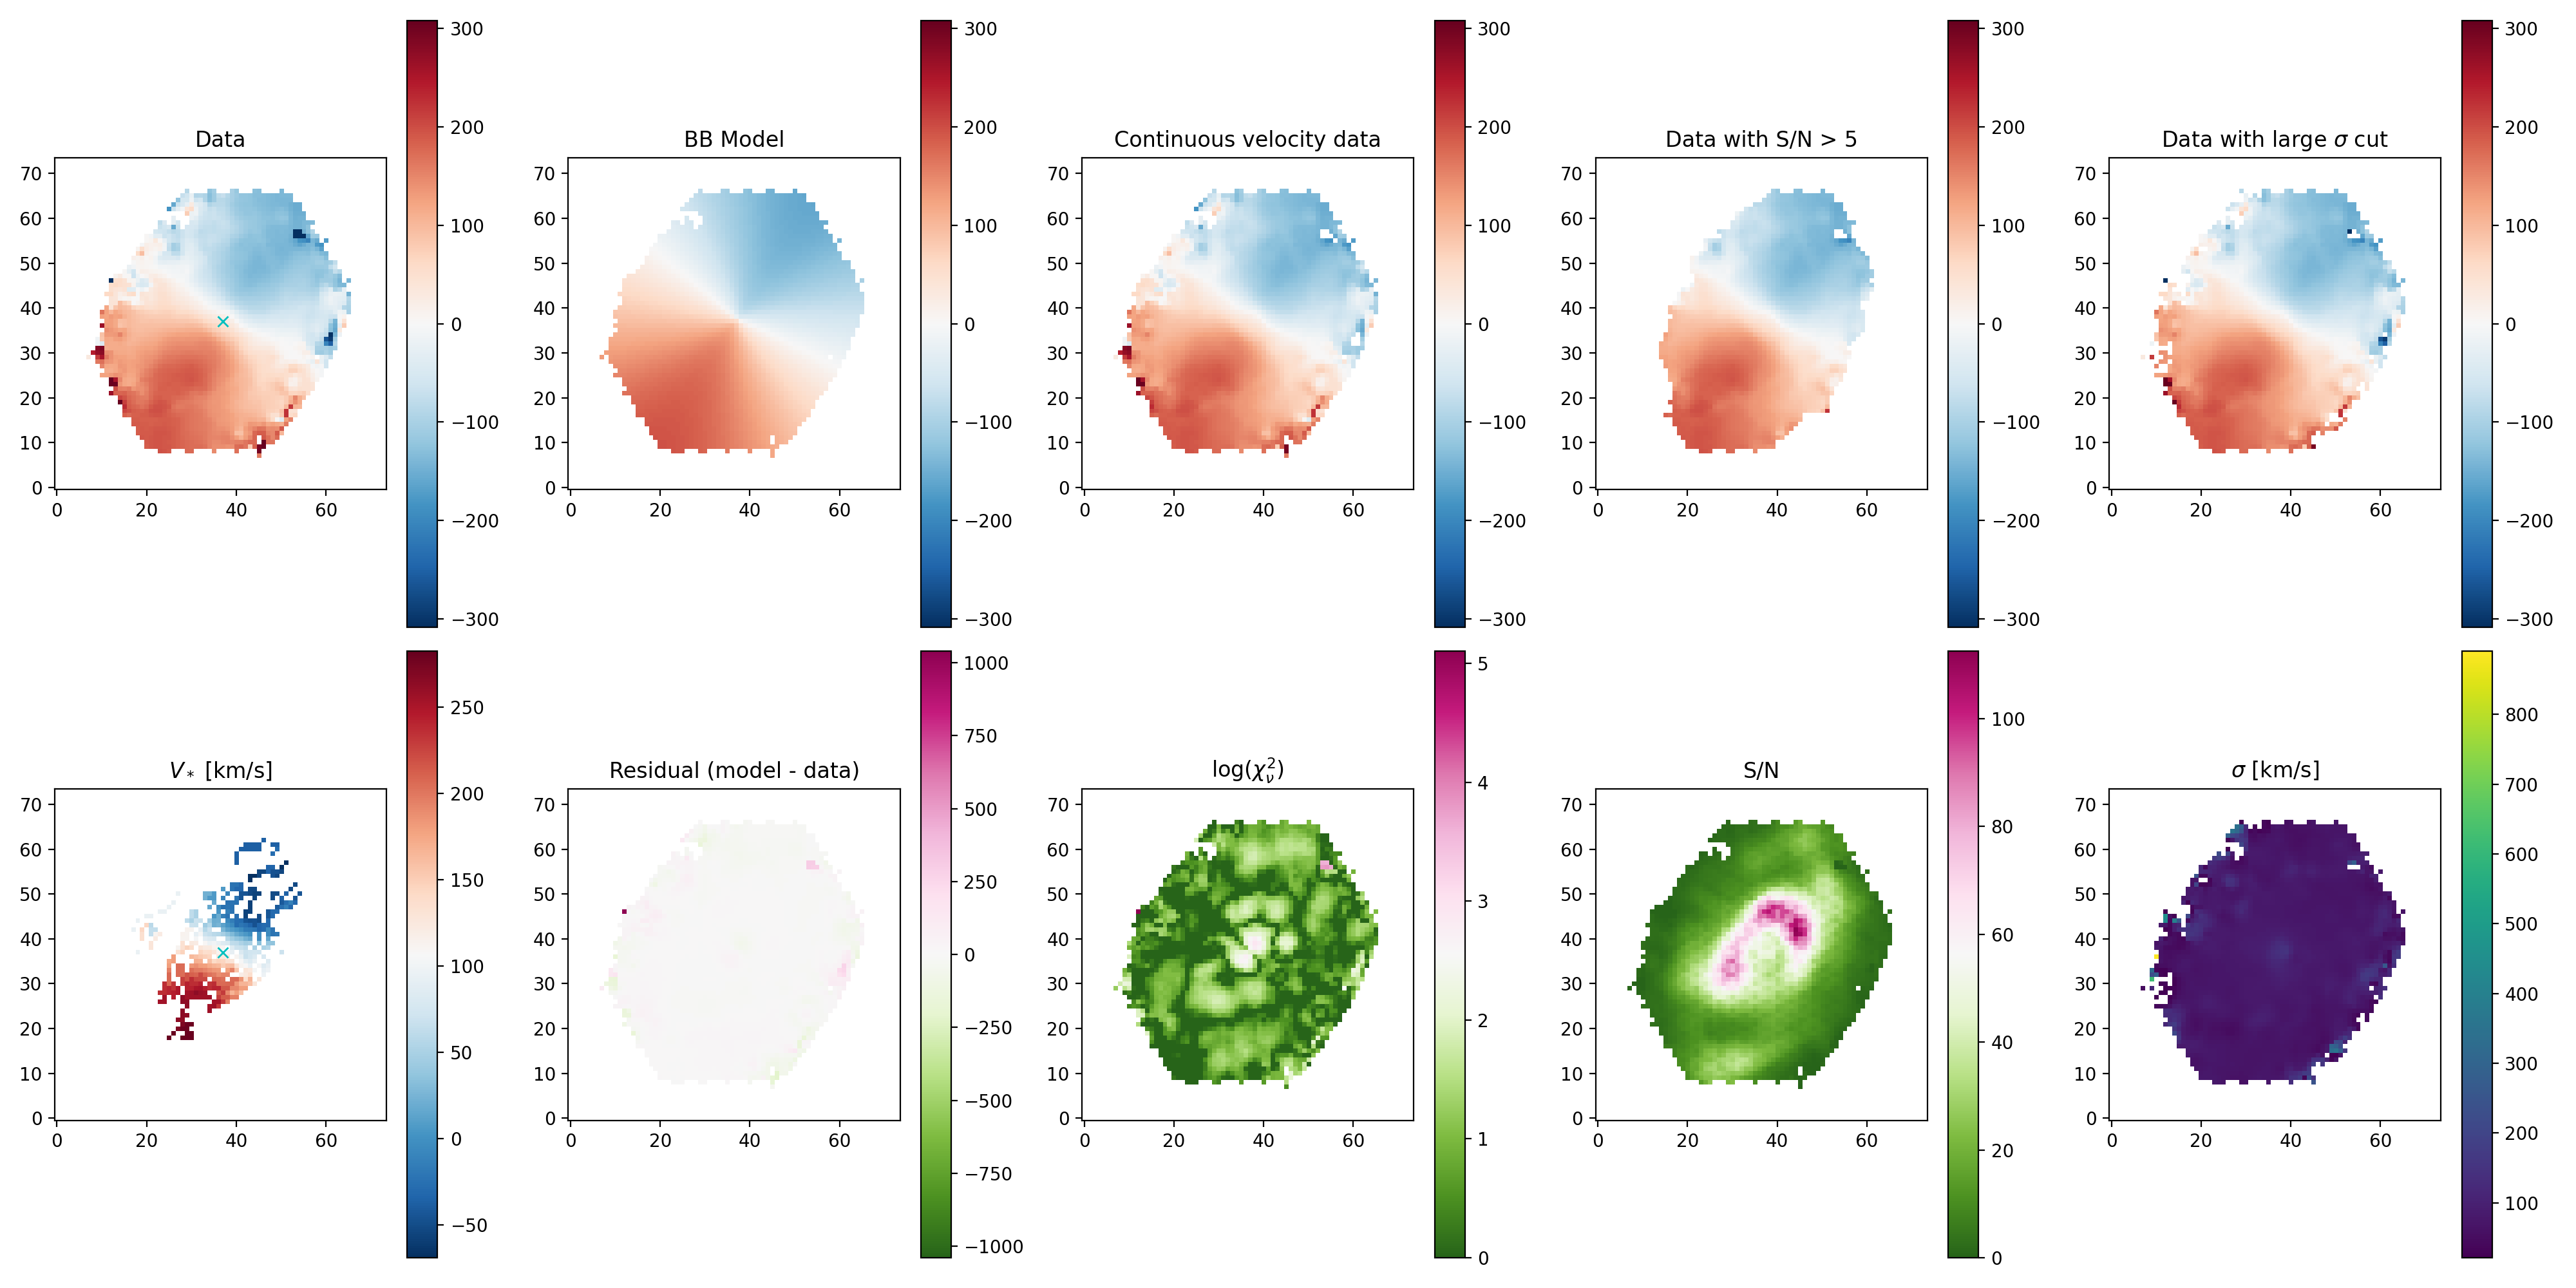

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_24440/3989014962.py:65: RuntimeWarning: divide by zero encountered in log10
  chi2_BB = np.max(np.log10(DRPmaps['Ha_vel_ivar']*(model_map_BB - mHa_vel)**2))
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_24440/3989014962.py:66: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(DRPmaps['Ha_vel_ivar']*(model_map_BB - mHa_vel)**2),


In [14]:
extreme3 = ma.max(ma.abs(mHa_vel_continuous))

plt.figure(figsize=(20,10))

plt.subplot(251)
plt.imshow(mHa_vel, origin='lower', cmap='RdBu_r', vmin=-extreme3, vmax=extreme3)
plt.plot(center[1], center[0], 'cx')
plt.colorbar()
plt.title('Data')

plt.subplot(252)
#v_max_model_BB = np.max(np.abs(model_map_BB - v_sys))
#plt.imshow(ma.array(model_map_BB - v_sys, mask=mHa_vel.mask), 
plt.imshow(ma.array(model_map_BB, mask=mHa_vel.mask), 
           vmin=-extreme3, vmax=extreme3, 
           origin='lower', 
           cmap='RdBu_r')
plt.colorbar()
plt.title('BB Model')

plt.subplot(253)
#plt.imshow(m3sHa_vel, origin='lower', cmap='RdBu_r', vmin=-extreme2, vmax=extreme2)
plt.imshow(mHa_vel_continuous, origin='lower', cmap='RdBu_r', vmin=-extreme3, vmax=extreme3)
plt.colorbar()
#plt.title(r'Data within 3$\sigma$')
plt.title('Continuous velocity data')

plt.subplot(254)
plt.imshow(m5Ha_vel, 
           origin='lower', 
           cmap='RdBu_r', 
           vmin=-extreme3, 
           vmax=extreme3)
plt.colorbar()
plt.title('Data with S/N > 5')

plt.subplot(255)
plt.imshow(mHa_vel_nonAGN, 
           origin='lower', 
           cmap='RdBu_r', 
           vmin=-extreme3, 
           vmax=extreme3)
plt.colorbar()
plt.title(r'Data with large $\sigma$ cut')

plt.subplot(256)
plt.imshow(mStar_vel - c*gal_oneD_fit_parameters_row['NSA_redshift'][0], 
           origin='lower', 
           cmap='RdBu_r')
plt.plot(center[1], center[0], 'cx')
plt.colorbar()
plt.title('$V_*$ [km/s]')

plt.subplot(257)
residual_BB = np.max(np.abs(model_map_BB - mHa_vel))
plt.imshow(model_map_BB - mHa_vel, 
           origin='lower', 
           cmap='PiYG_r', 
           vmin=-residual_BB, 
           vmax=residual_BB)
plt.colorbar()
plt.title('Residual (model - data)')

plt.subplot(258)
chi2_BB = np.max(np.log10(DRPmaps['Ha_vel_ivar']*(model_map_BB - mHa_vel)**2))
plt.imshow(np.log10(DRPmaps['Ha_vel_ivar']*(model_map_BB - mHa_vel)**2), 
           cmap='PiYG_r', 
           origin='lower', 
           vmin=0, 
           vmax=chi2_BB)
plt.colorbar()
plt.title(r'log($\chi^2_{\nu}$)')

plt.subplot(259)
plt.imshow(ma.array(np.abs(SN), mask=mHa_vel.mask), 
           cmap='PiYG_r', 
           origin='lower', 
           vmin=0, 
           vmax=np.max(np.abs(SN)))
plt.colorbar()
plt.title('S/N')

plt.subplot(2, 5, 10)
plt.imshow(mHa_sigma, origin='lower')
plt.colorbar()
plt.title('$\sigma$ [km/s]')

'''
plt.subplot(234)
#plt.imshow(model_map_tanh - v_sys, origin='lower', cmap='RdBu_r')
plt.imshow(model_map_tanh, origin='lower', cmap='RdBu_r')
plt.colorbar()
plt.title('tanh Model')

plt.subplot(235)
residual_tanh = np.max(np.abs(model_map_tanh - mHa_vel))
plt.imshow(model_map_tanh - mHa_vel, origin='lower', cmap='PiYG_r', vmin=-residual_tanh, vmax=residual_tanh)
plt.colorbar()
plt.title('Residual (model - data)')

plt.subplot(236)
plt.imshow(model_map_BB - model_map_tanh, origin='lower', cmap='RdBu_r')
plt.colorbar()
plt.title('Model difference (BB - tanh)')
'''
plt.tight_layout();

# Test `plot_rot_curve`

<IPython.core.display.Javascript object>


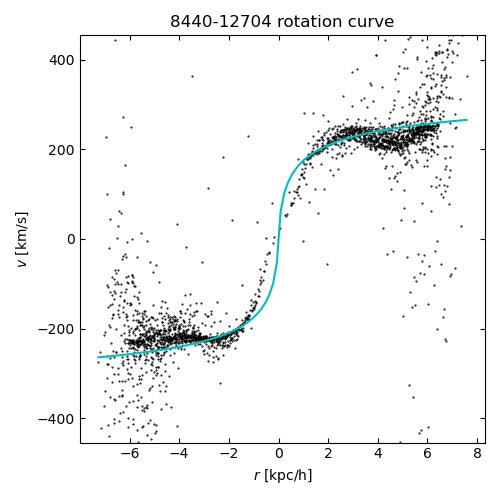

In [16]:
#plot_rot_curve(mHa_vel, mHa_vel_ivar, best_fit_values_degrees, pix_scale_factor, gal_ID, 'BB');
plot_rot_curve(mHa_vel, mHa_vel_ivar, map_fit_params_dict, pix_scale_factor, gal_ID, 'BB');
#plot_rot_curve(m5Ha_vel, mHa_vel_ivar, map_fit_params_dict, pix_scale_factor, gal_ID, 'BB')

plt.tight_layout();

<IPython.core.display.Javascript object>


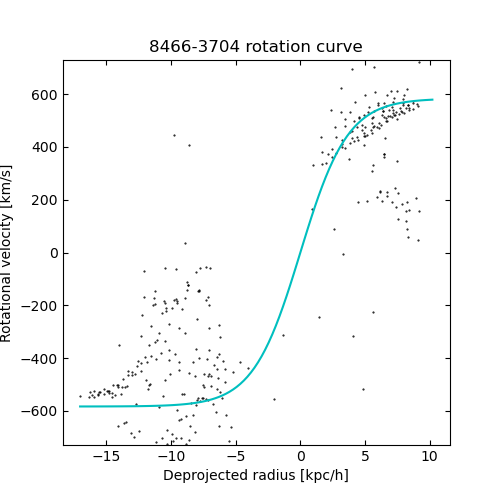

In [15]:
plot_rot_curve(mHa_vel, mHa_vel_ivar, best_fit_values_degrees, pix_scale_factor, gal_ID, 'tanh')

In [40]:
model_map_BB_masked = ma.array(model_map_BB, mask=np.zeros(map_shape))

plot_rot_curve(model_map_BB_masked, 
               mHa_vel_ivar, 
               map_fit_params_dict, #best_fit_values_degrees, 
               pix_scale_factor, 
               gal_ID, 
               'BB');

<IPython.core.display.Javascript object>

# Test `find_center`

In [9]:
maybe_center = find_center(mHa_vel)

In [10]:
maybe_center

(43, 46)

<IPython.core.display.Javascript object>


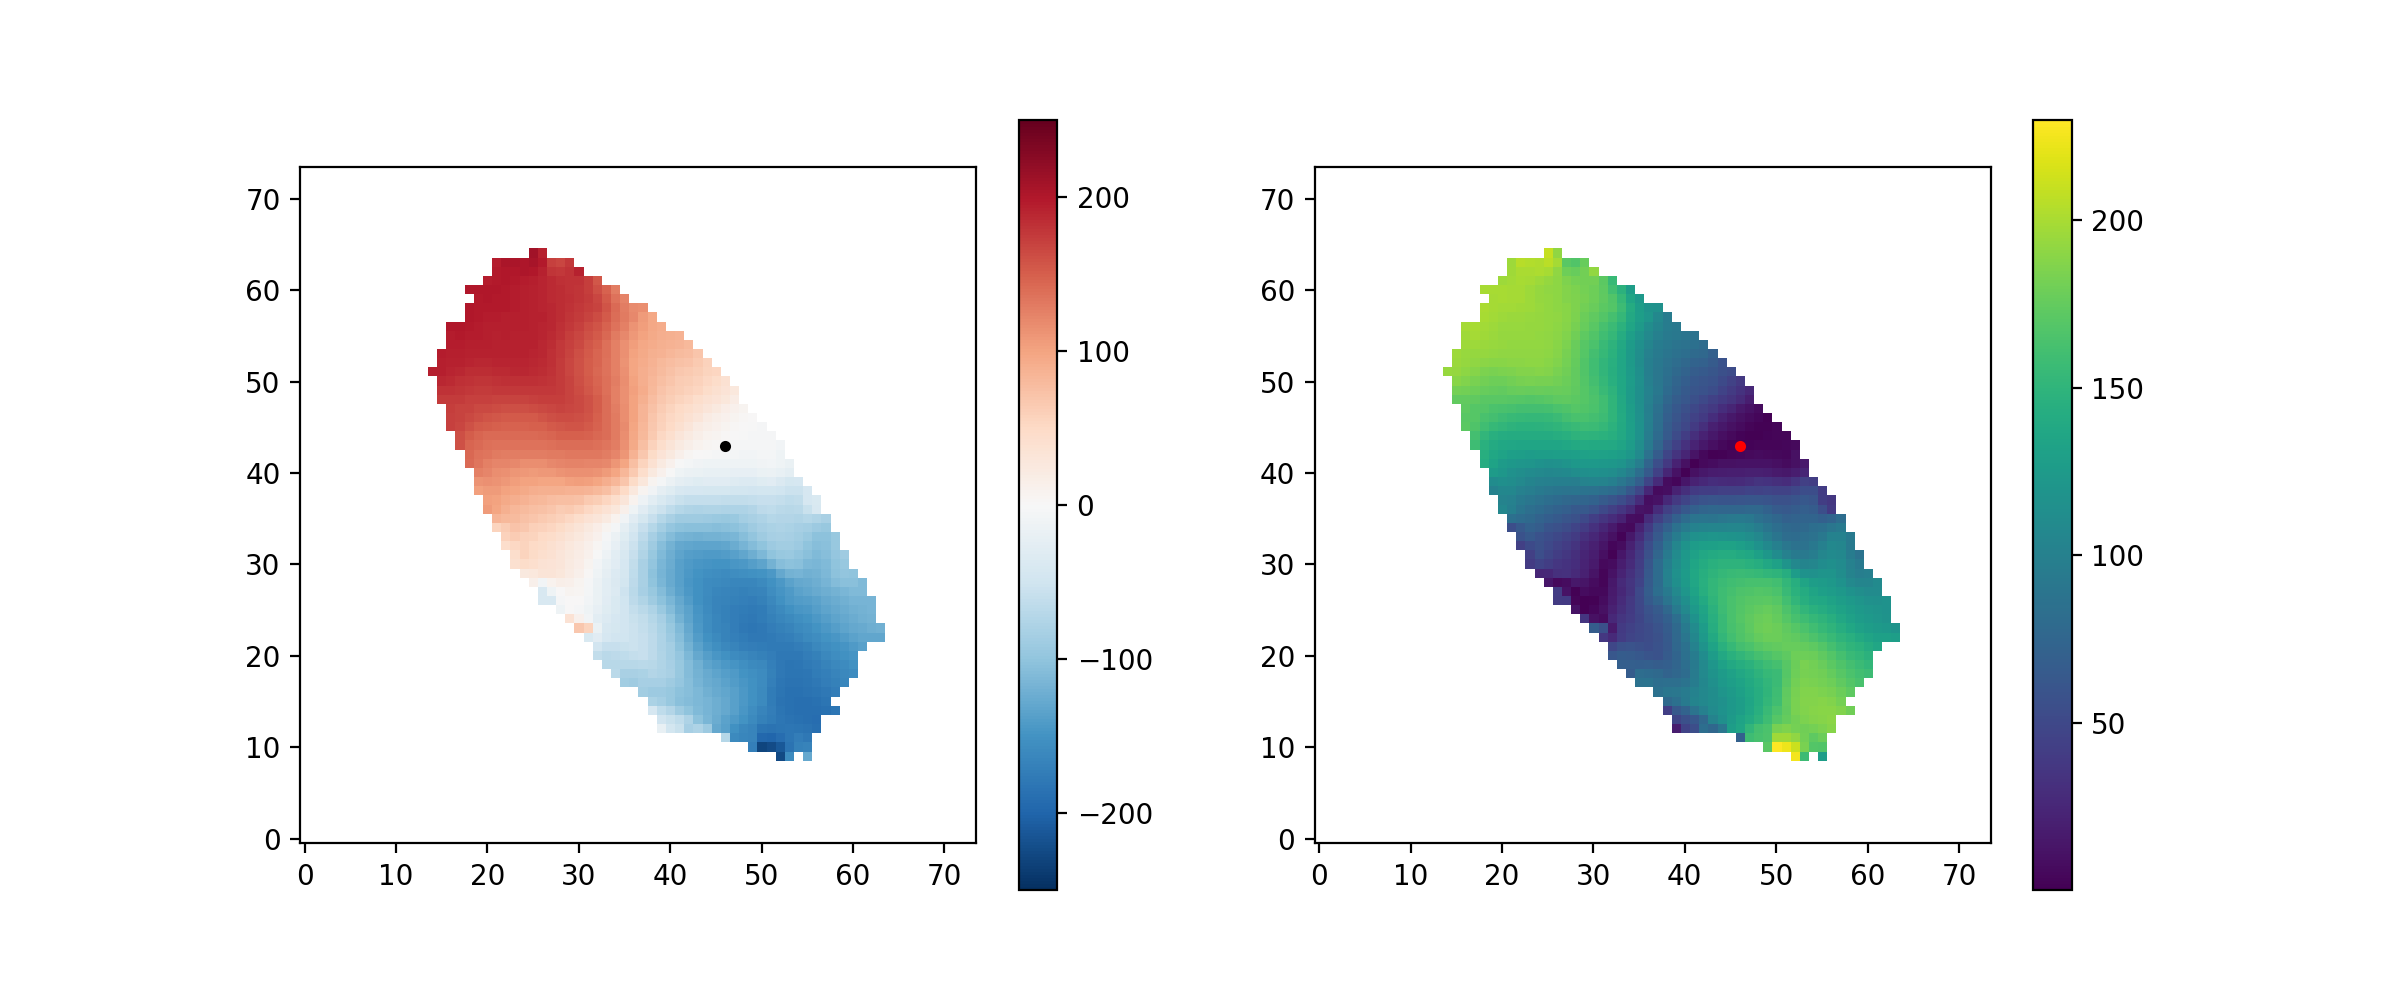

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(mHa_vel, origin='lower', cmap='RdBu_r', vmin=-250, vmax=250)
plt.plot(maybe_center[1], maybe_center[0], 'k.')
plt.colorbar()

plt.subplot(122)
plt.imshow(np.abs(mHa_vel), origin='lower')
plt.plot(maybe_center[1], maybe_center[0], 'r.')
plt.colorbar();

In [12]:
x = np.arange(map_shape[0])
X, Y = np.meshgrid(x,x)

<IPython.core.display.Javascript object>


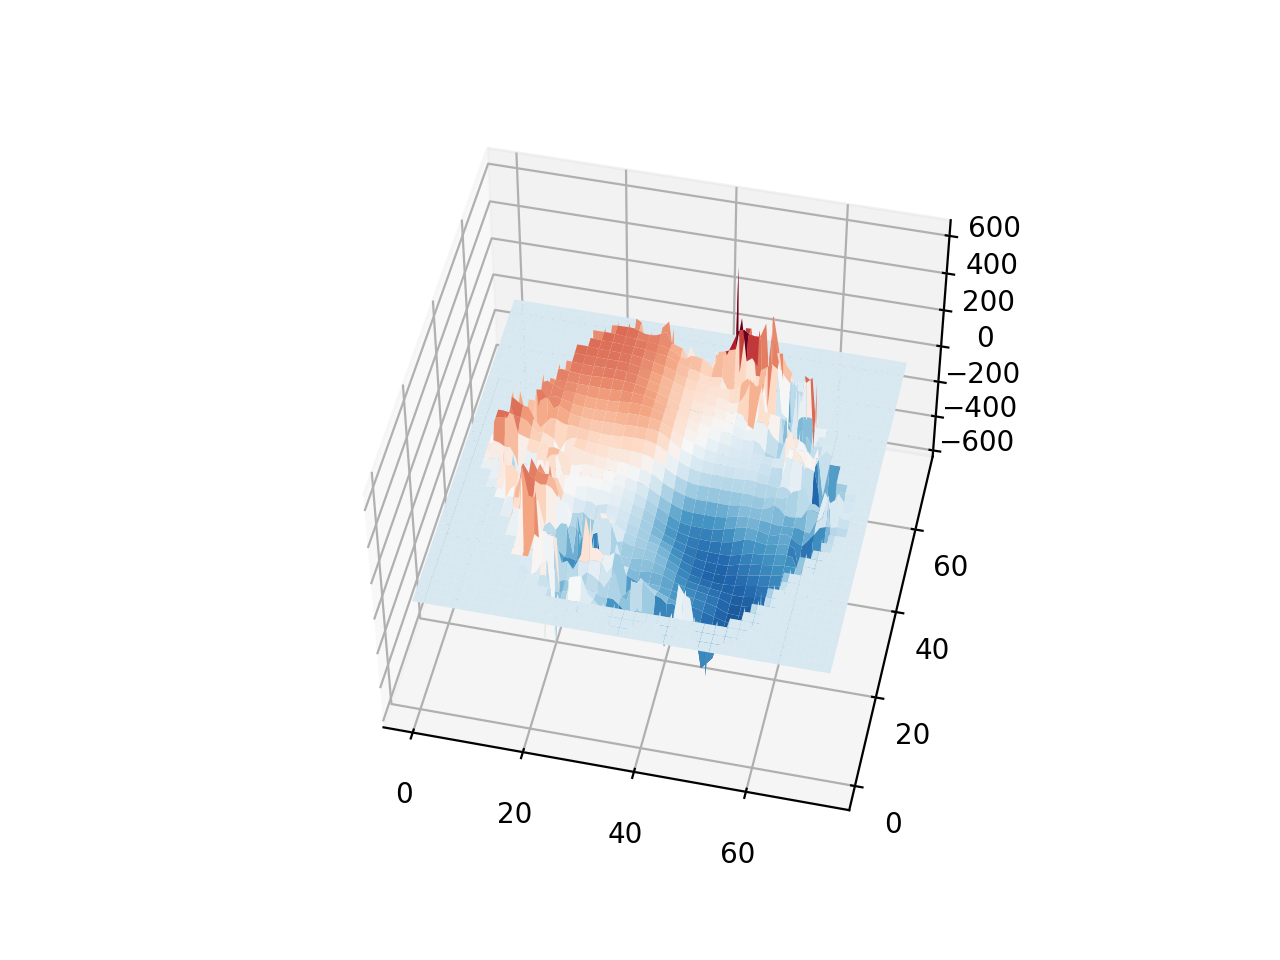

In [17]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, mHa_vel, cmap='RdBu_r');
#plt.colorbar();

In [28]:
i_angle

1.0683978716829448

# Distribution in spaxel velocities

Maybe it's possible to mask out spaxels with velocities more than some $\sigma$ from the mean?

In [74]:
stddev = ma.std(mHa_vel.flatten())

stddev2 = ma.std(mHa_vel[ma.abs(mHa_vel) <= v_sys + stddev].flatten())

print('Standard deviation:', stddev)
print('Standard deviation of shrunken sample:', stddev2)

Standard deviation: 300.20788607569176
Standard deviation of shrunken sample: 155.45924030745323


<IPython.core.display.Javascript object>


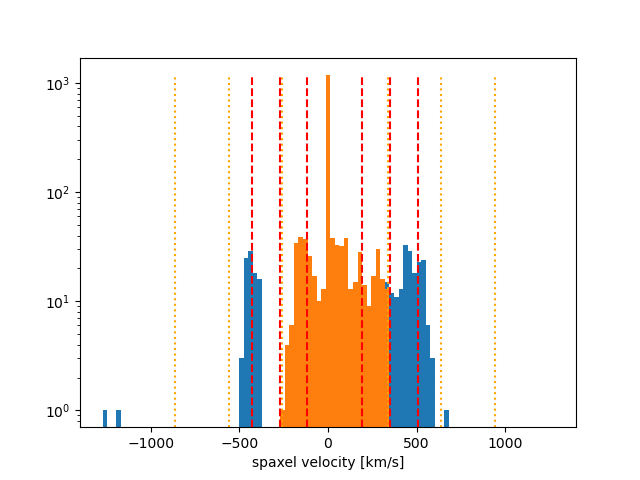

In [77]:
plt.figure()

plt.hist(mHa_vel.flatten(), bins=np.linspace(-extreme2, extreme2, 100))
plt.hist(mHa_vel[ma.abs(mHa_vel) <= v_sys + stddev].flatten(), bins=np.linspace(-extreme2, extreme2, 100))

plt.vlines(v_sys + [stddev, 2*stddev, 3*stddev, -stddev, -2*stddev, -3*stddev], 0,1200, 
           colors='orange', linestyles=':')
plt.vlines(v_sys + [stddev2, 2*stddev2, 3*stddev2, -stddev2, -2*stddev2, -3*stddev2], 0,1200, 
           colors='red', linestyles='--')

plt.yscale('log')

plt.xlabel('spaxel velocity [km/s]');

Instead, let's try to find the group of pixels that all go together.  Bin the data in bin widths of 50 km/s, and group all bins together which link back to the bin with the most spaxels in it.

In [14]:
bin_width = 10

extreme2 = np.max(np.abs(mHa_vel))

vel_bin_counts, vel_bin_edges = np.histogram(mHa_vel.flatten(), 
                                             bins=np.arange(-extreme2, extreme2 + bin_width, bin_width))

In [15]:
# Find the bin with the most counts, and build out from there

center_bin = np.argmax(vel_bin_counts)

################################################################################
# First, find the highest bin in which data is connected back to this central 
# bin
#-------------------------------------------------------------------------------
max_bin = center_bin + 1

while max_bin < len(vel_bin_counts) and vel_bin_counts[max_bin] > 0:
    max_bin += 1

max_vel = vel_bin_edges[max_bin]
################################################################################


################################################################################
# Next, find the lowest bin in which data is connected back to this central bin
#-------------------------------------------------------------------------------
min_bin = center_bin - 1

while vel_bin_counts[min_bin] > 0 and min_bin > 0:
    min_bin -= 1
    
min_vel = vel_bin_edges[min_bin]
################################################################################

In [16]:
good_vel = np.logical_and(mHa_vel >= min_vel, mHa_vel <= max_vel)

<IPython.core.display.Javascript object>


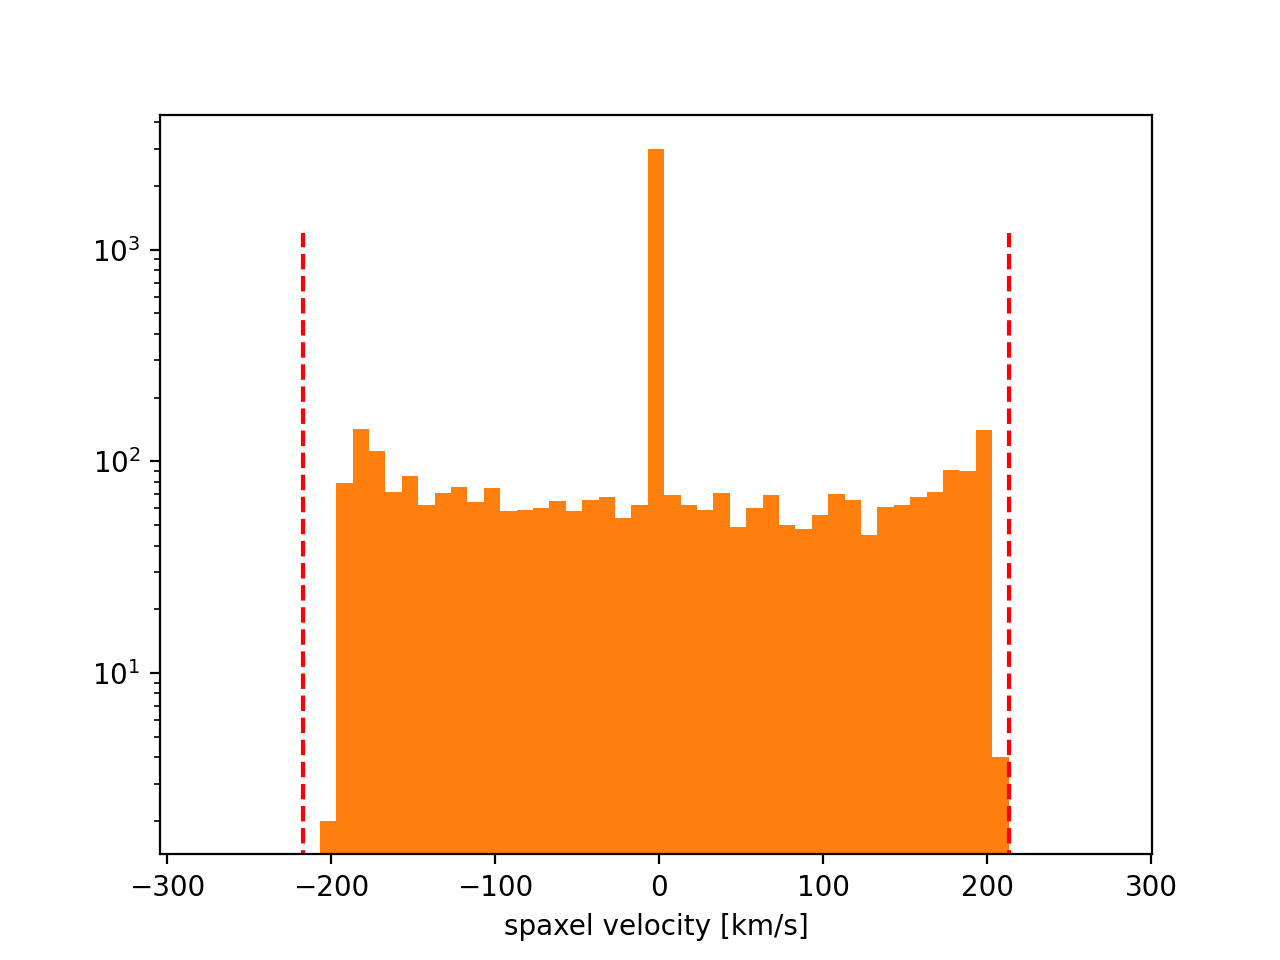

In [17]:
plt.figure()

plt.hist(mHa_vel.flatten(), bins=np.arange(-extreme2, extreme2, bin_width))
plt.hist(mHa_vel[good_vel].flatten(), bins=np.arange(-extreme2, extreme2, bin_width))

plt.vlines([min_vel, max_vel], 0,1200, colors='red', linestyles='--')

plt.yscale('log')

plt.xlabel('spaxel velocity [km/s]');

<IPython.core.display.Javascript object>


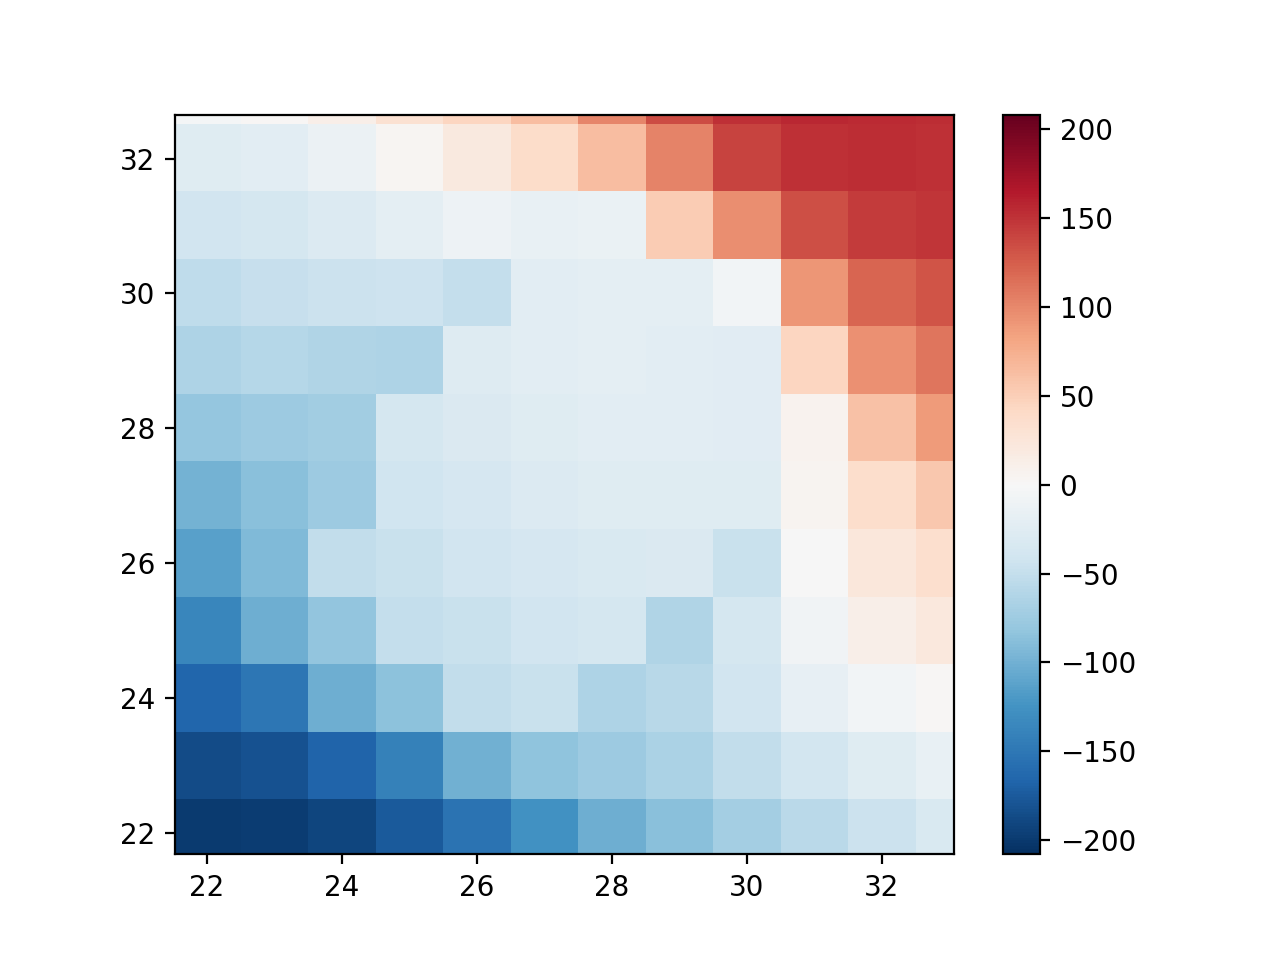

In [76]:
plt.figure()

plt.imshow(mHa_vel, origin='lower', cmap='RdBu_r', vmin=-extreme2, vmax=extreme2)

plt.colorbar();

# Distribution in spaxel line widths ($\sigma$)

Maybe it's possible to mask out spaxels with line widths larger than some value (to mask out AGN-like features)?

In [38]:
sigma_min = ma.min(mHa_sigma)
sigma_max = ma.max(mHa_sigma)

print(sigma_min, sigma_max)

37.911045 129.82555


<IPython.core.display.Javascript object>


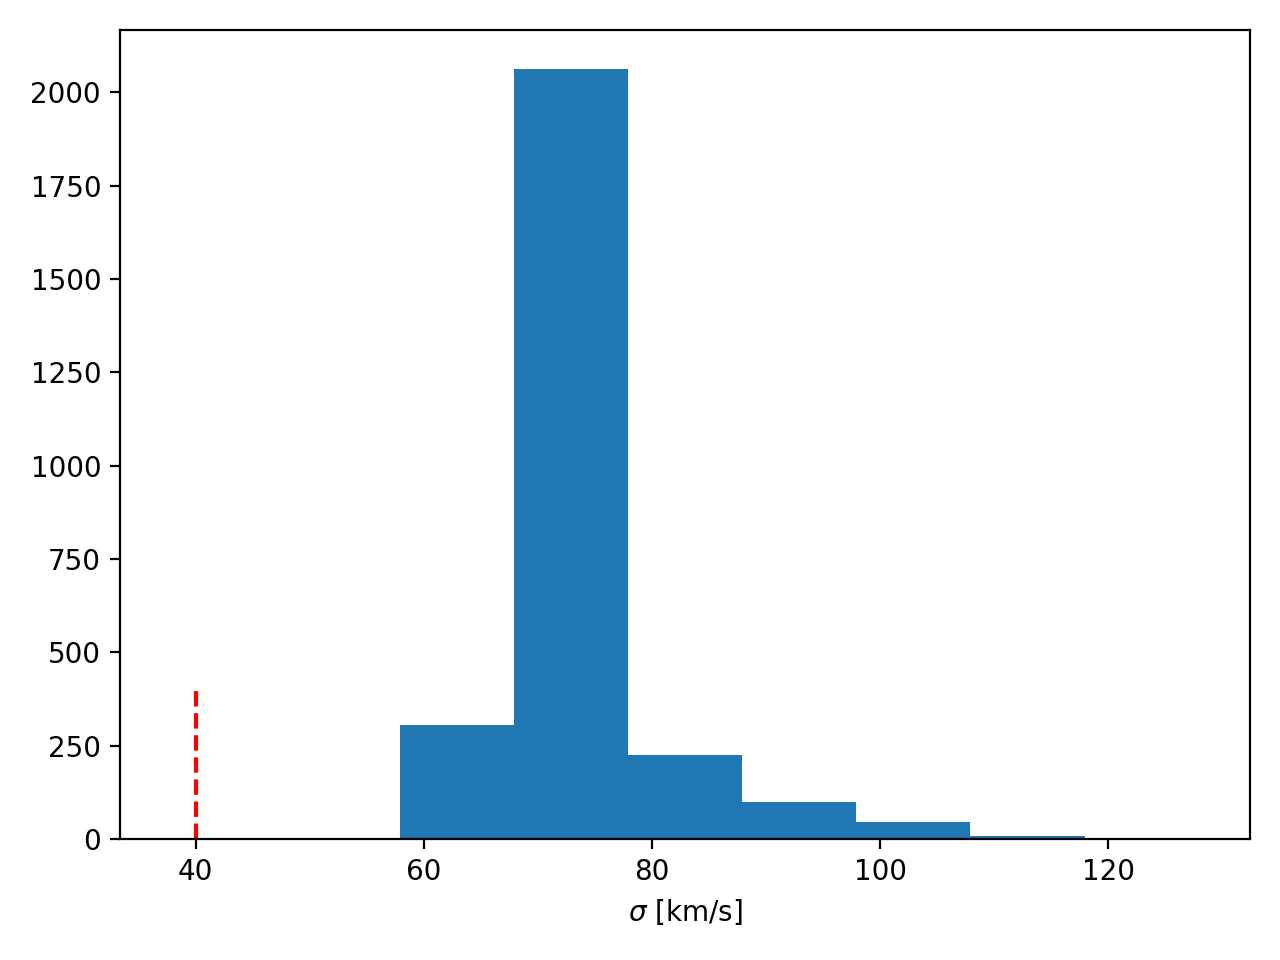

In [40]:
plt.figure()

plt.hist(mHa_sigma.compressed(), bins=np.arange(sigma_min, sigma_max, 10))
plt.vlines(max_sigma, 0,400, colors='red', linestyles='--')

plt.xlabel('$\sigma$ [km/s]')

plt.tight_layout();

# Cut based on unmasked fraction of spaxels

If there are too few spaxels left to fit, then we should not be using that fit.  So, what's the right place to cut this?

In [26]:
N_tot = mHa_vel.shape[0]*mHa_vel.shape[1]

N_normal = np.sum(~mHa_vel.mask)

N_continuous = np.sum(~mHa_vel_continuous.mask)

N_SN = np.sum(~m5Ha_vel.mask)

N_AGN = np.sum(~mHa_vel_nonAGN.mask)

In [27]:
print('Unmasked fraction of spaxels for:')
print('Normal:    ', N_normal/N_tot)
print('Continuous:', N_continuous/N_tot)
print('S/N:       ', N_SN/N_tot)
print('AGN:       ', N_AGN/N_tot)

Unmasked fraction of spaxels for:
Normal:     0.359375
Continuous: 0.244140625
S/N:        0.005859375
AGN:        0.1904296875
